In [19]:
# overhead

import logging
import math
import random
import numpy as np
import time
import torch as t
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

In [26]:
# environment parameters

FRAME_TIME = 0.1     # time interval
GRAVITY_ACCEL = 9.81 # gravity constant
BOOST_ACCEL = 0.18   # thrust constant
rho = 1.4            # density in kg/m^3
CD = 0.8             # coefficient of drag
A = 25               # Reference Area in m^2 


In [27]:
class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    @staticmethod
    def forward(state, action):

        """
        action: Main engine thrust(z),Side thrust(x) and Drag
        action[0]: thrust in x direction. (𝑥 = 𝐻𝑜𝑟𝑖𝑧𝑜𝑛𝑡𝑎𝑙 𝑃𝑜𝑠𝑖𝑡𝑖𝑜𝑛 𝑜𝑓 𝑡ℎ𝑒 𝑅𝑜𝑐𝑘𝑒𝑡)
        action[1]: thrust in z direction. (𝑧 = 𝑉𝑒𝑟𝑡𝑖𝑐𝑎𝑙 𝑃𝑜𝑠𝑖𝑡𝑖𝑜𝑛 𝑜𝑓 𝑡ℎ𝑒 𝑅𝑜𝑐𝑘𝑒)
        action[2]: Drag in z direction = 0.5*rho*velocity^2*A*CD.range (1,0) 
        
        states:
        state[0] = x
        state[1] = thrust_x
        state[2] = z
        state[3] = thrust_z
        state[4] = z1
        state[5] = D
        """
        
        # Apply gravity
        # Note: Here gravity is used to change velocity which is the second element of the state vector
        # Normally, we would do x[1] = x[1] + gravity * delta_time
        # but this is not allowed in PyTorch since it overwrites one variable (x[1]) that is part of the computational graph to be differentiated.
        # Therefore, I define a tensor dx = [0., gravity * delta_time], and do x = x + dx. This is allowed... 
        delta_state_gravity = t.tensor([0.,0.,0.,0.,0.,0., GRAVITY_ACCEL * FRAME_TIME])

        # Thrust and Drag
        
        thrust_x = action[0]
        thrust_z = action[1]*2.5
        drag_y   = action[2]*0.5*rho*A*CD
        
        # Note: Same reason as above. Need a 2-by-1 tensor.
        delta_state_thrust_x = GRAVITY_ACCEL * FRAME_TIME * t.tensor([0., 1., 0., 0., 0., 0.]) * thrust_x
        delta_state_thrust_z = BOOST_ACCEL * FRAME_TIME * t.tensor([0., 0., 0., 1., 0., 0.]) * thrust_z
        delta_state_drag = BOOST_ACCEL * FRAME_TIME * t.tensor([0., 0., 0., 0., 0., 1.]) * drag_y

        # Update velocity
        state = state - delta_state_thrust_z + delta_state_thrust_x - delta_state_drag
        
        # Update state
        # Note: Same as above. Use operators on matrices/tensors as much as possible. Do not use element-wise operators as they are considered inplace.
        step_mat = t.tensor([[1., FRAME_TIME,0.,0., 0., 0.],
                            [0., 1.,0.,0.,0.,0.],
                             [0.,0.,1.,FRAME_TIME,0.,0.],
                             [0.,0.,0.,1.,0.,0.],
                             [0.,0.,0.,0.,1.,FRAME_TIME],
                             [0.,0.,0.,0.,0.,1.]])
        
        state = t.matmul(step_mat, state)

        return state

In [28]:
# a deterministic controller
# Note:
# 0. You only need to change the network architecture in "__init__"
# 1. nn.Sigmoid outputs values from 0 to 1, nn.Tanh from -1 to 1
# 2. You have all the freedom to make the network wider (by increasing "dim_hidden") or deeper (by adding more lines to nn.Sequential)
# 3. Always start with something simple

class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: up to you
        """
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_output),
            # You can add more layers here
            nn.Sigmoid()
        )

    def forward(self, state):
        action = self.network(state)
        return action

In [29]:
# the simulator that rolls out x(1), x(2), ..., x(T)
# Note:
# 0. Need to change "initialize_state" to optimize the controller over a distribution of initial states
# 1. self.action_trajectory and self.state_trajectory stores the action and state trajectories along time

class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        # initial position of x,z,thrust and drag
        state = [1., -1., 1., 1., 1., 1.]  # TODO: need batch of initial states
        return t.tensor(state, requires_grad=False).float()

    def error(self, state):
        return state[0]**2 + state[1]**2 + state[2]**2 + state[3]**2 + state[4]**2 + state[5]**2

In [32]:
# set up the optimizer
# Note:
# 0. LBFGS is a good choice if you don't have a large batch size (i.e., a lot of initial states to consider simultaneously)
# 1. You can also try SGD and other momentum-based methods implemented in PyTorch
# 2. You will need to customize "visualize"
# 3. loss.backward is where the gradient is calculated (d_loss/d_variables)
# 4. self.optimizer.step(closure) is where gradient descent is done

niter = [] # No: of iterations
llist = [] # List of loss
class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01)

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward()
            return loss
        self.optimizer.step(closure)
        return closure()
    
    def train(self, epochs):
        for epoch in range(epochs):
            loss = self.step()
            llist.append(loss.detach())
            niter.append(epoch+1)
            print('[%d] loss: %.3f' % (epoch + 1, loss))
            
            if epoch % 10 == 0:
                self.visualize(epoch,loss)


    def visualize(self,epoch,loss):
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        x = data[:, 0]
        z = data[:, 2]
        
        T = range(self.simulation.T)
        velocity_x  = data[:, 1]
        velocity_z  = data[:, 3]
        data1 = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        thrust_x  = data1[:, 1]
        thrust_z  = data1[:, 3]
        z1 = data1[:, 4]
        drag_y = data1[:, 5]

        fig,ax = plt.subplots(1,4, figsize=(24, 6))
        
        ax[0].plot(x, z)
        ax[0].set_xlabel('x')
        ax[0].set_ylabel('z')
        ax[0].set(title='Rocket Position')
        
        ax[1].plot(T, thrust_x, c='b', label='x thrust')
        ax[1].plot(T, thrust_z, c='r', label='z thrust')
        ax[1].set_xlabel('Timeframe (0.1s)')
        ax[1].set_ylabel('Thrust')
        ax[1].set(title='Thrust')
         
        ax[2].plot(T, drag_y, c='b', label='y Drag')
        ax[2].set_xlabel('Timeframe (0.1s)')
        ax[2].set_ylabel('Drag')
        ax[2].set(title='Drag')
        
        
        ax[3].plot(niter, llist, c='b')
        ax[3].set_xlabel('Iterations')
        ax[3].set_ylabel('Loss')
        ax[3].set(title='Convergence')
                   
        fig.tight_layout()
        
        plt.show()

[1] loss: 16759.340


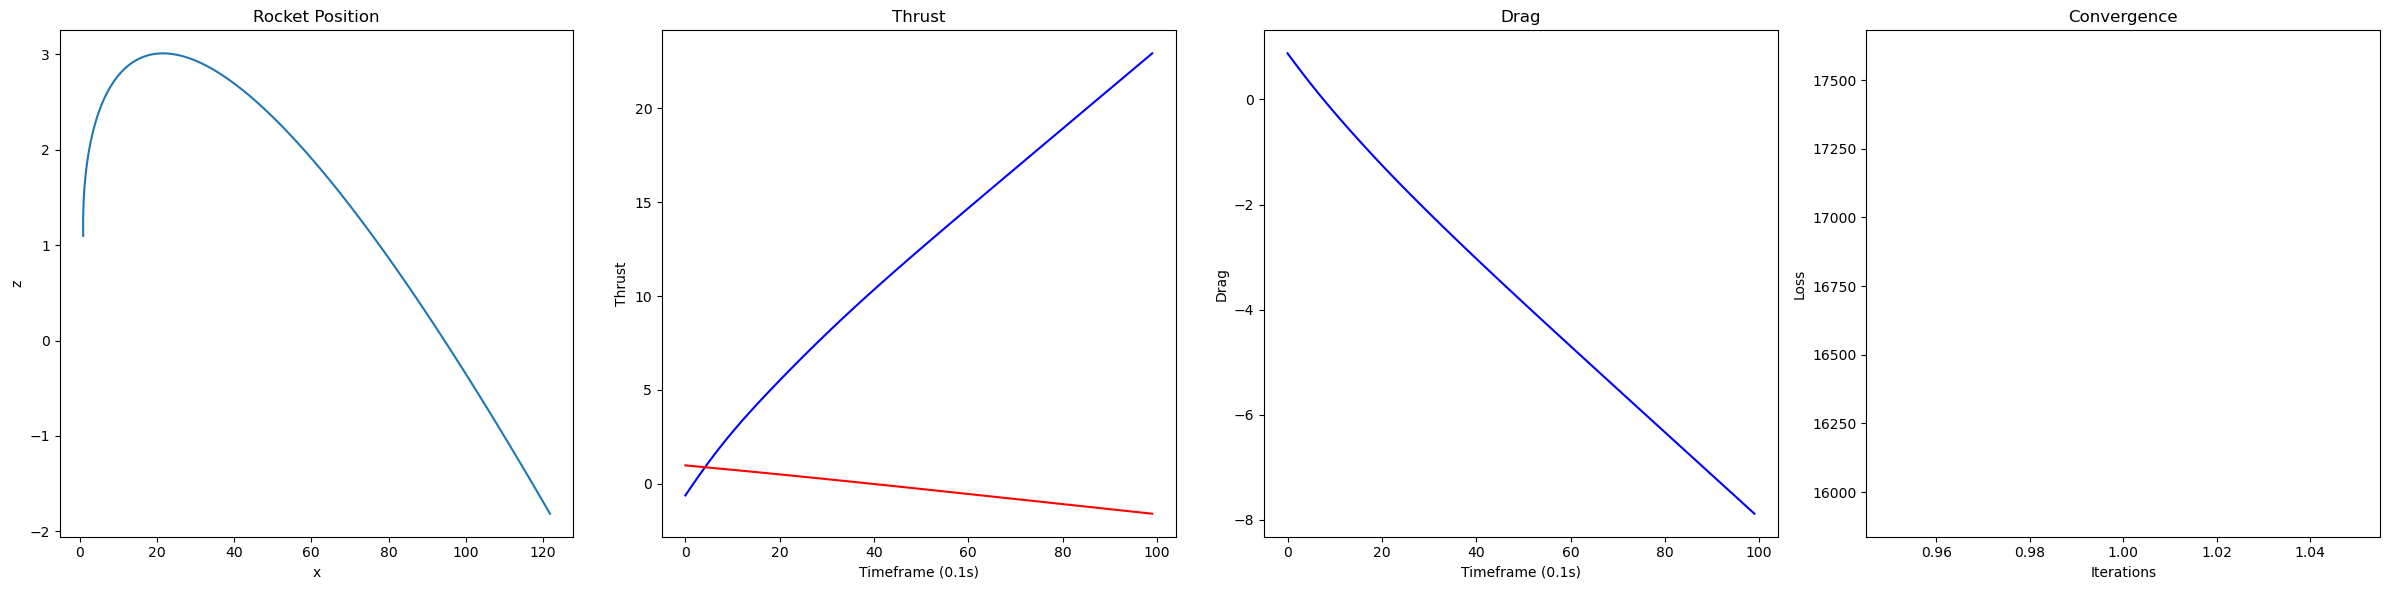

[2] loss: 10220.503
[3] loss: 5702.229
[4] loss: 2976.380
[5] loss: 1834.613
[6] loss: 1130.504
[7] loss: 630.100
[8] loss: 382.834
[9] loss: 220.968
[10] loss: 131.159
[11] loss: 84.334


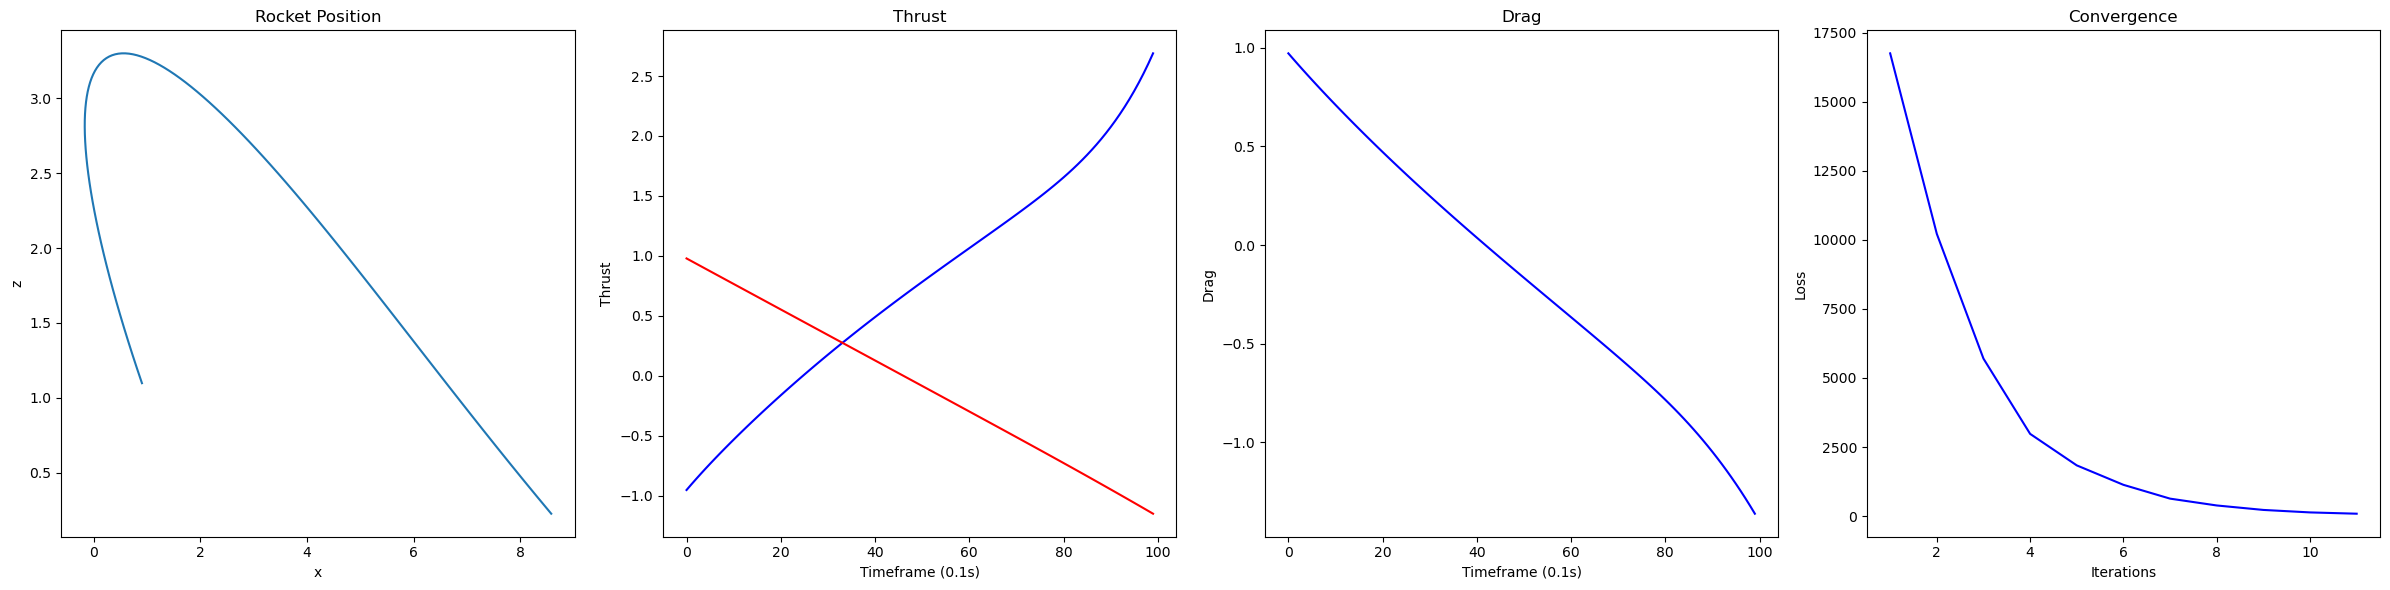

[12] loss: 55.417
[13] loss: 35.639
[14] loss: 22.888
[15] loss: 15.484
[16] loss: 11.178
[17] loss: 8.575
[18] loss: 6.906
[19] loss: 5.810
[20] loss: 5.129
[21] loss: 4.720


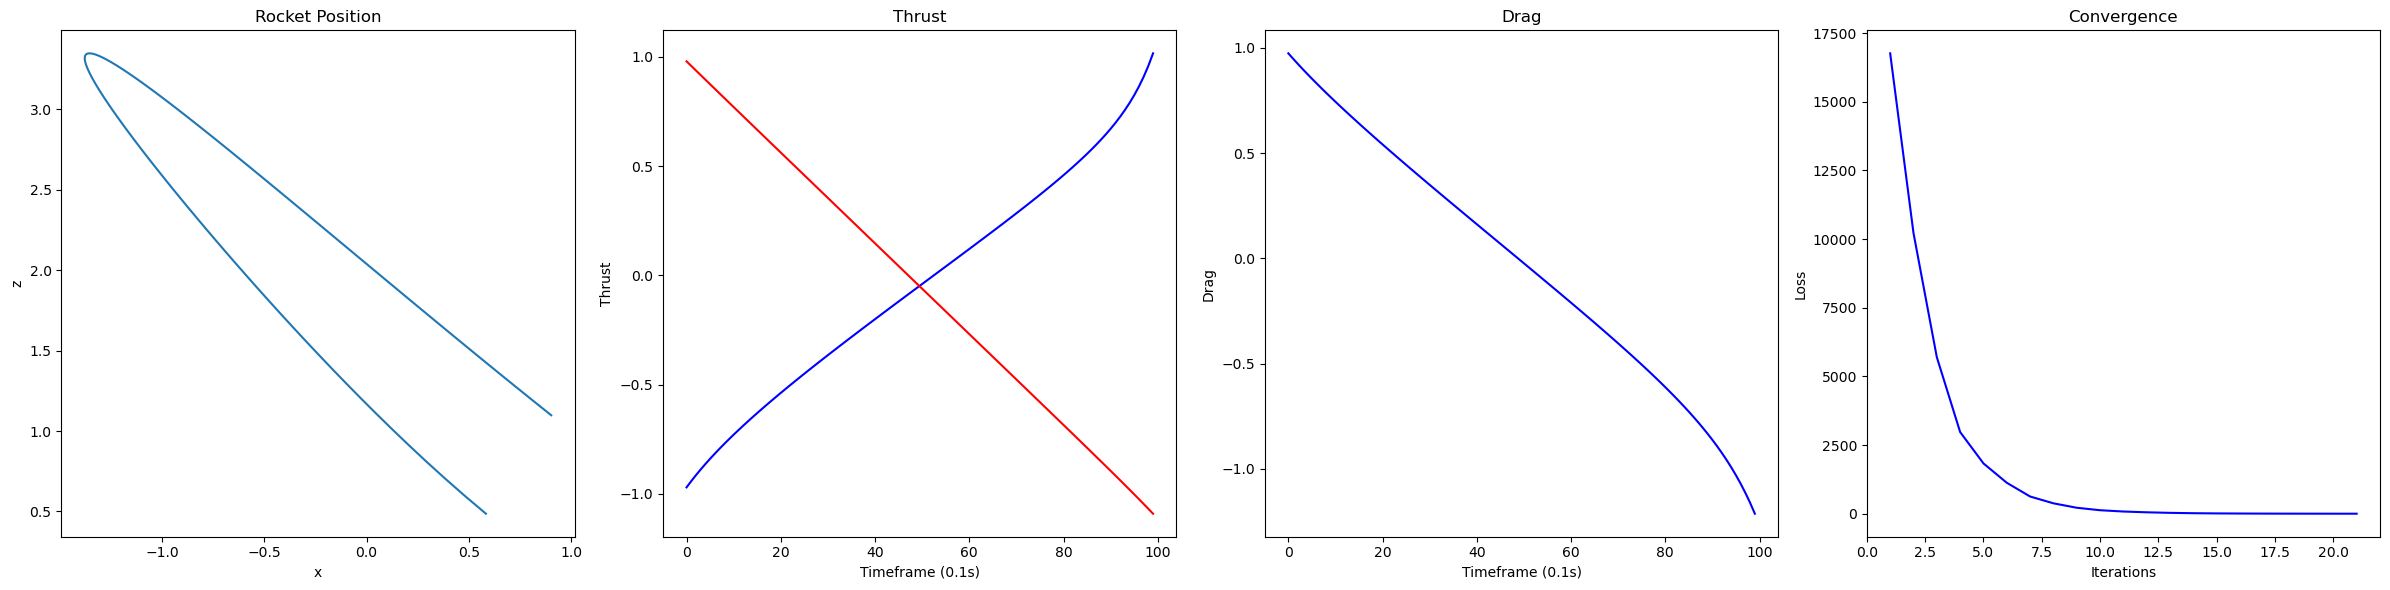

[22] loss: 4.465
[23] loss: 4.292
[24] loss: 4.159
[25] loss: 4.036
[26] loss: 3.889
[27] loss: 3.433
[28] loss: 3.241
[29] loss: 2.953
[30] loss: 2.636
[31] loss: 2.232


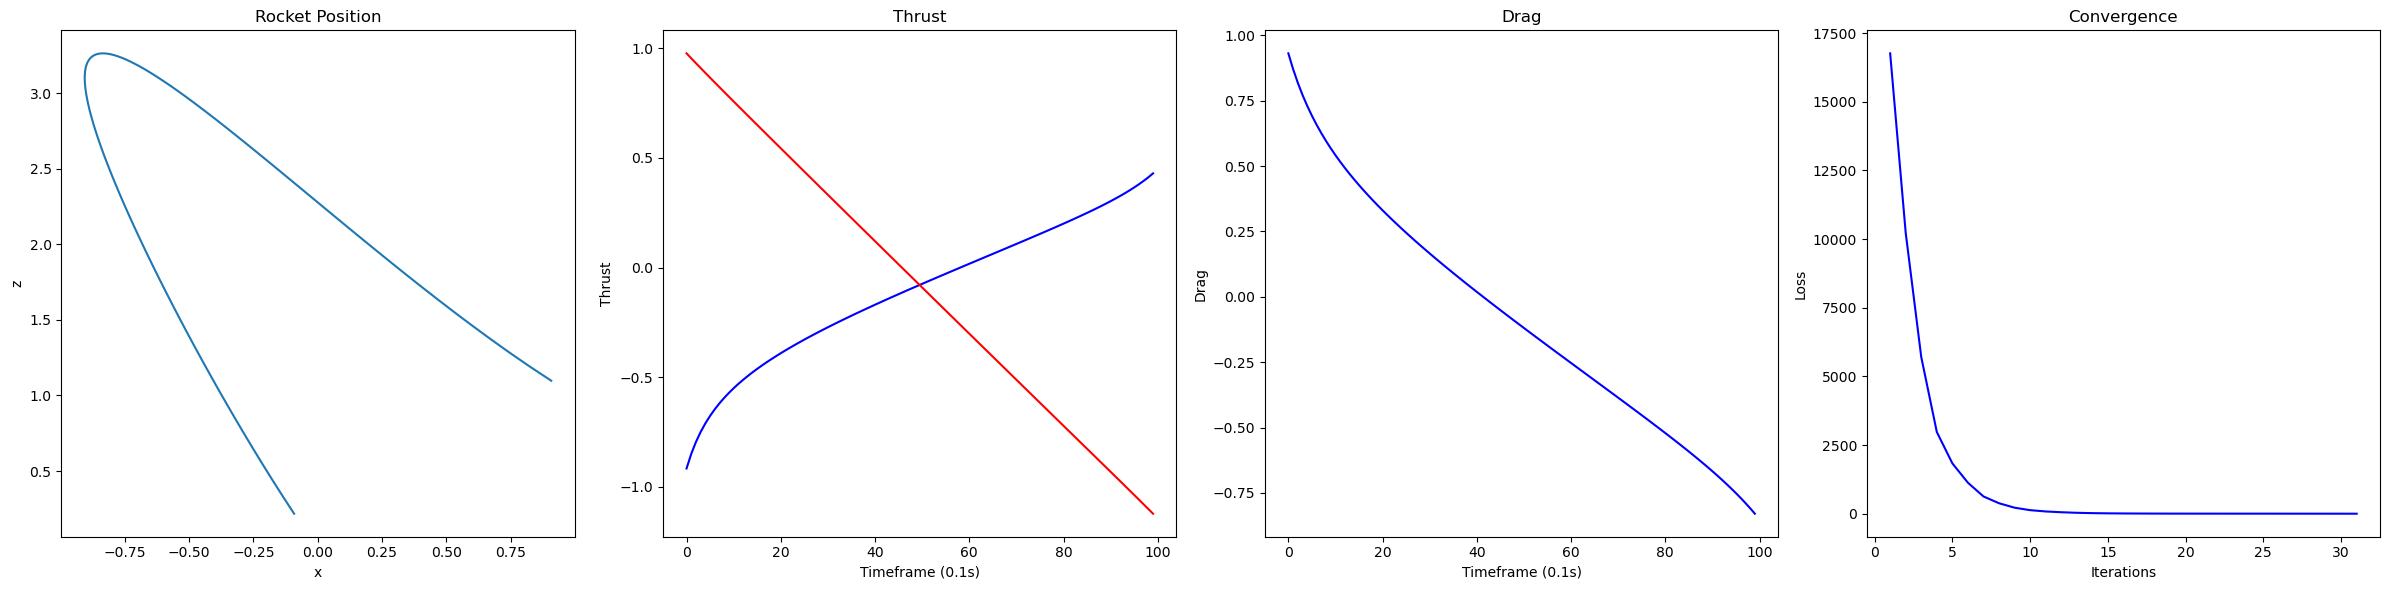

[32] loss: 1.946
[33] loss: 1.644
[34] loss: 1.294
[35] loss: 1.007
[36] loss: 0.801
[37] loss: 0.644
[38] loss: 0.529
[39] loss: 0.441
[40] loss: 0.373
[41] loss: 0.318


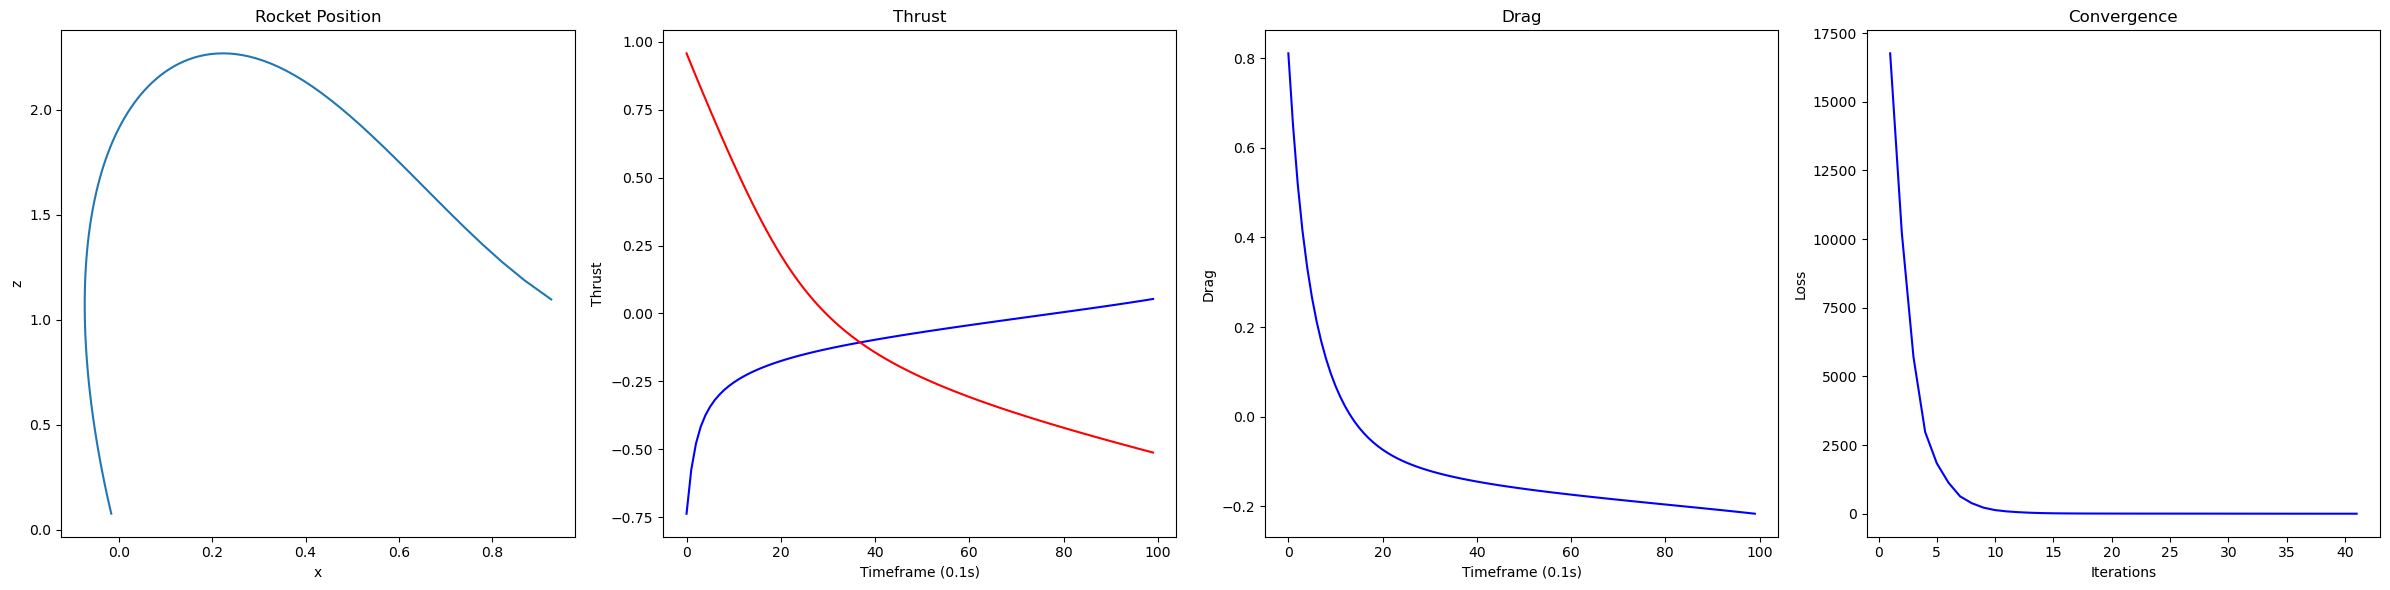

[42] loss: 0.275
[43] loss: 0.242
[44] loss: 0.215
[45] loss: 0.193
[46] loss: 0.175
[47] loss: 0.161
[48] loss: 0.149
[49] loss: 0.139
[50] loss: 0.131
[51] loss: 0.124


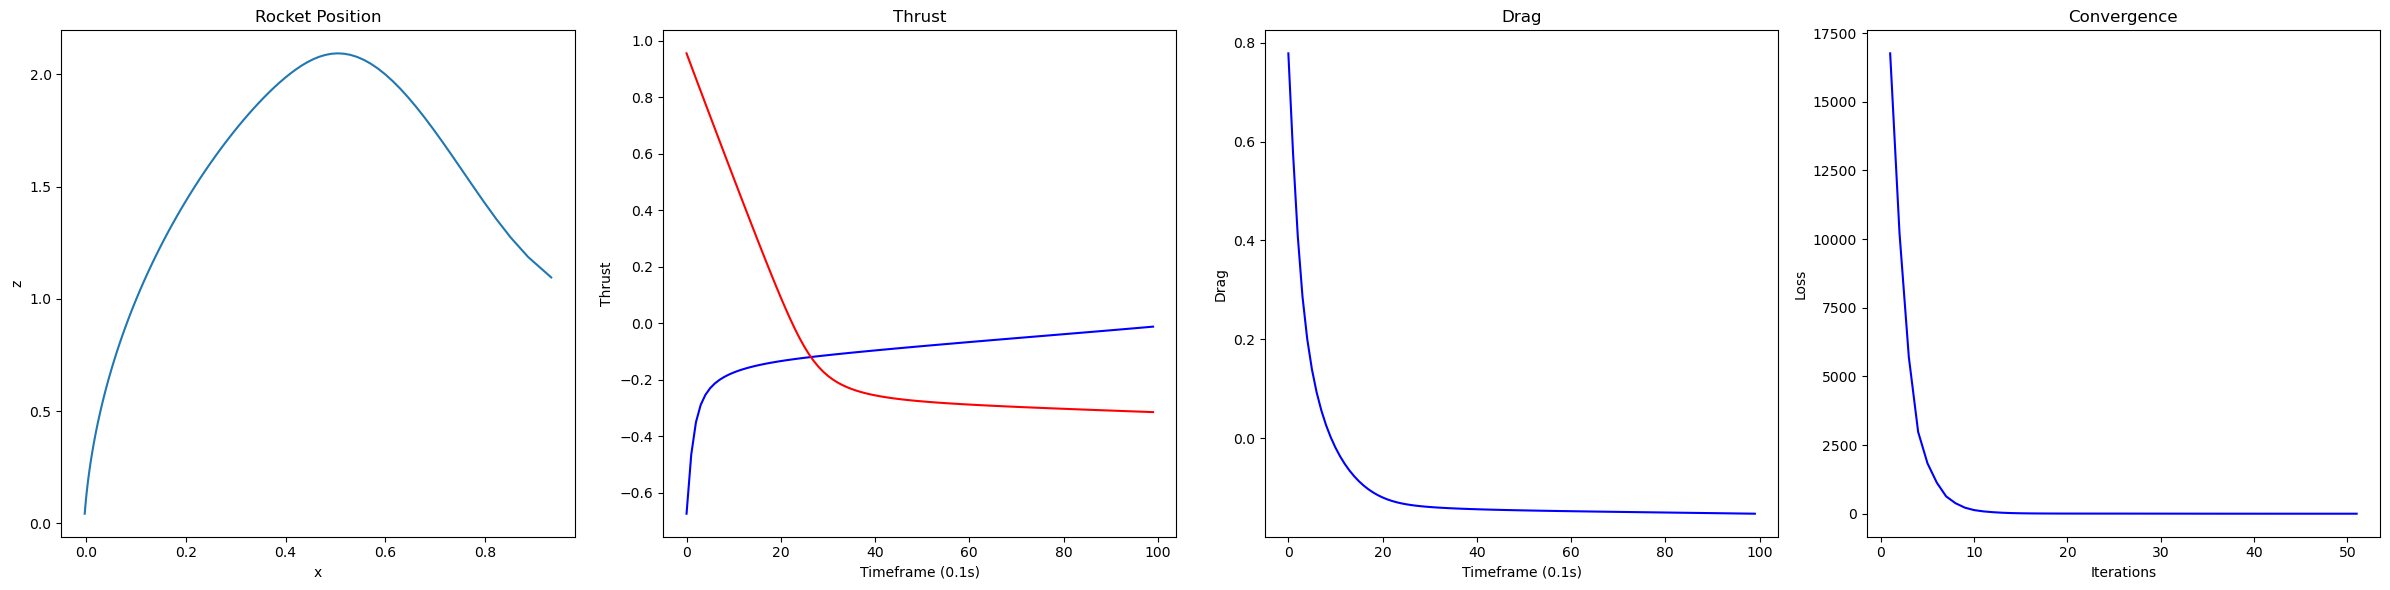

[52] loss: 0.119
[53] loss: 0.114
[54] loss: 0.110
[55] loss: 0.107
[56] loss: 0.104
[57] loss: 0.102
[58] loss: 0.100
[59] loss: 0.099
[60] loss: 0.097
[61] loss: 0.096


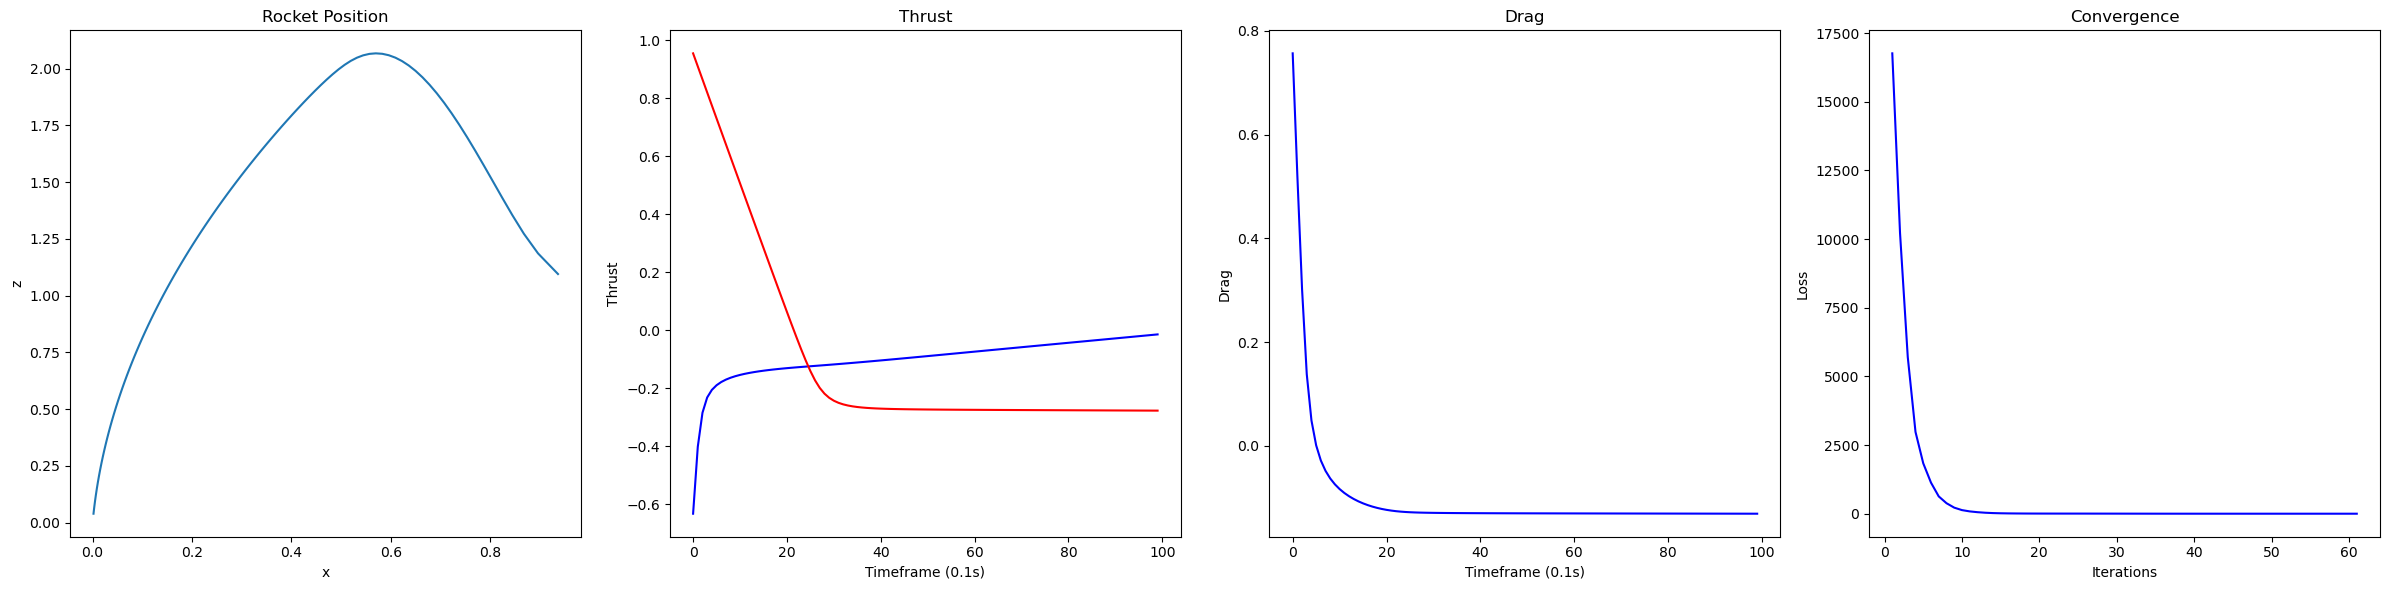

[62] loss: 0.095
[63] loss: 0.094
[64] loss: 0.093
[65] loss: 0.093
[66] loss: 0.092
[67] loss: 0.092
[68] loss: 0.092
[69] loss: 0.091
[70] loss: 0.091
[71] loss: 0.091


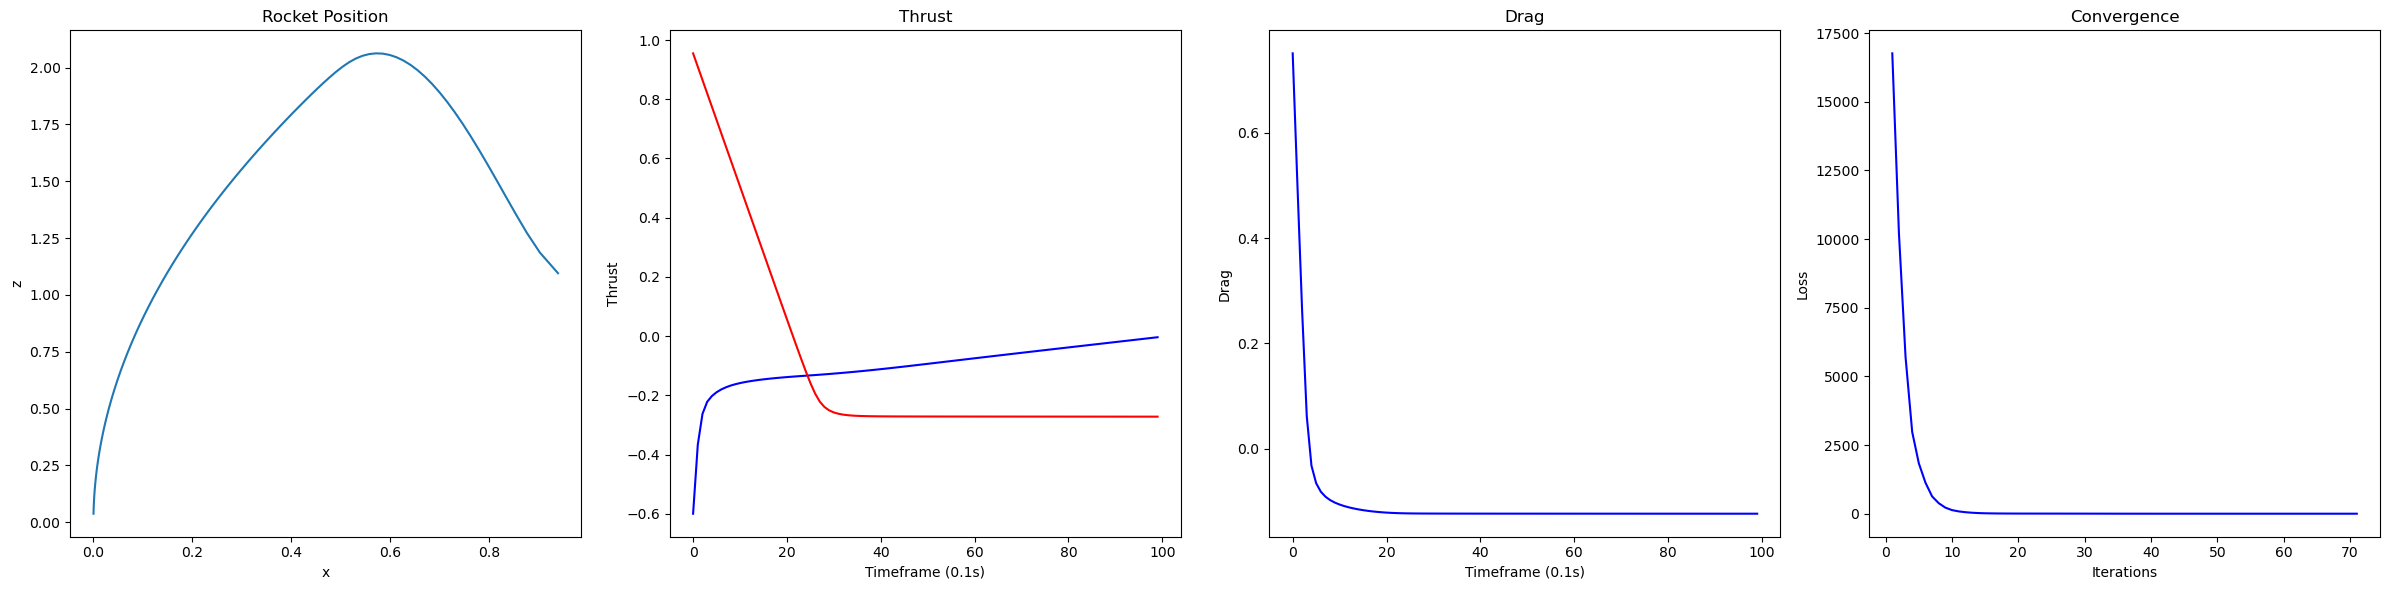

[72] loss: 0.090
[73] loss: 0.090
[74] loss: 0.090
[75] loss: 0.090
[76] loss: 0.090
[77] loss: 0.089
[78] loss: 0.089
[79] loss: 0.089
[80] loss: 0.089
[81] loss: 0.089


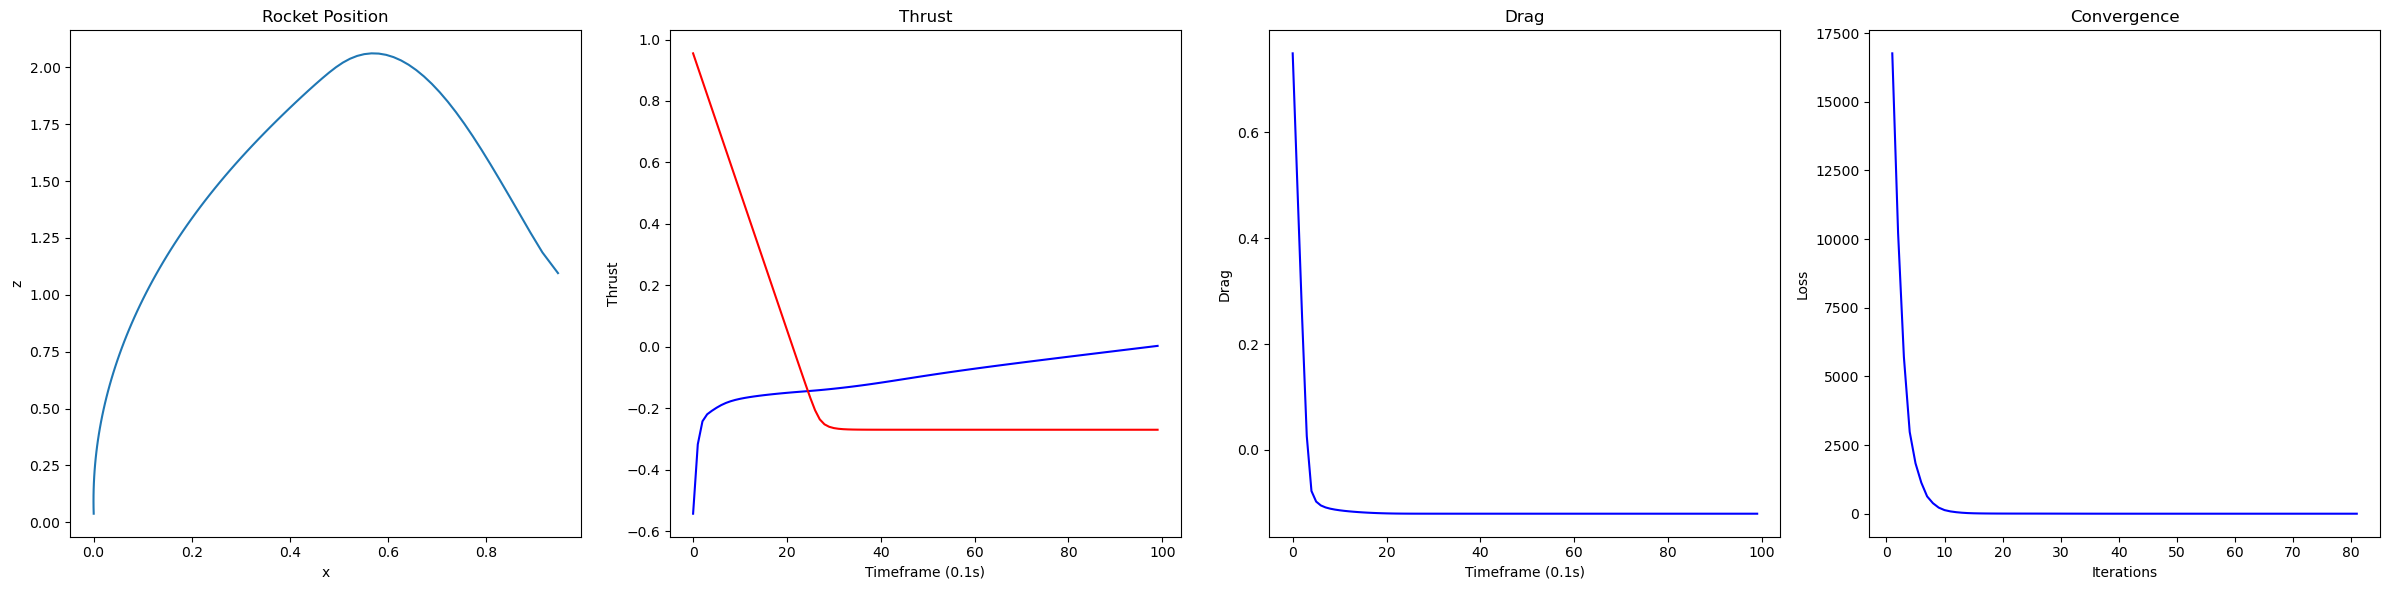

[82] loss: 0.089
[83] loss: 0.089
[84] loss: 0.089
[85] loss: 0.089
[86] loss: 0.089
[87] loss: 0.088
[88] loss: 0.088
[89] loss: 0.088
[90] loss: 0.088
[91] loss: 0.088


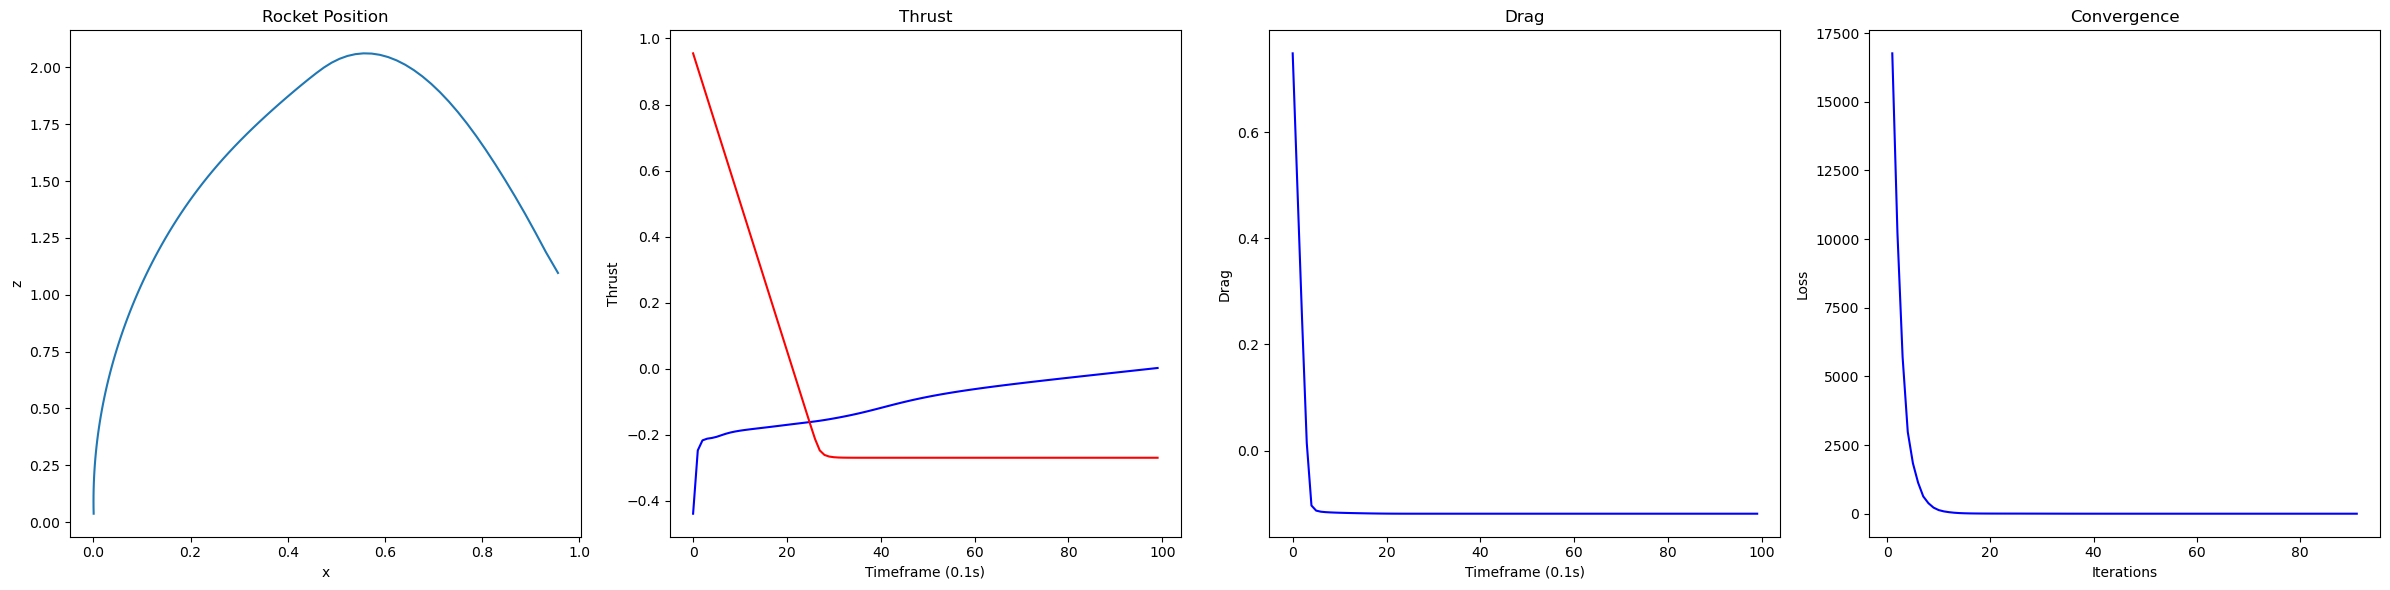

[92] loss: 0.088
[93] loss: 0.088
[94] loss: 0.088
[95] loss: 0.088
[96] loss: 0.088
[97] loss: 0.088
[98] loss: 0.088
[99] loss: 0.088
[100] loss: 0.088


In [33]:
# Now it's time to run the code!

T = 100  # number of time steps
dim_input = 6  # state space dimensions
dim_hidden = 12  # latent dimensions
dim_output = 3  # action space dimensions
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c, d, T)  # define simulation
o = Optimize(s)  # define optimizer
o.train(100)  # solve the optimization problem